### Simple Workflow Example
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebooke uses a synthetic example to showcase the LOOP to FloPy workflow as follows:

1. Project parameters
2. Geological model
3. Meshing
4. Flow model
5. Plotting 

### 1. Project parameters

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_42404\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [2]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# ------------- DISCRETISATION PARAMETERS -----------------------#
P.triExeName = '../exe/triangle.exe'
P.workspace = '../modelfiles/'
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [(2500, 2500)] #[(2000, 2000), (4000,4000)]
P.xypumpbores = [] #[(2000, 2000), (4000,4000)]
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)] 
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
P.nobs = len(P.xyobsbores)
P.npump = len(P.xypumpbores)

P.r = 40        # refining factor for model boundary. High r has refined edges
P.w = 100      # Interior boundary
P.boundmaxtri = 50000 # 8/5 - was 20000
P.modelmaxtri = 50000 # 8/5 - was 30000
P.angle = 32   # minimum triangle angles
P.nlv  = 30  # 8/5 was 50 - number of layers for voxel transect grid

P.radius1 = 100 # radius of inner circle around pumping bores
P.radius2 = 200 # radius of outer circle around pumping bores
P.boremaxtri = 99999

P.geo_bores = ['P1', 'P2', 'P3', 'P4']
P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]

# ------------- GEO MODEL PARAMETERS -----------------------#
#P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 4000, 2000) # fault end points
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault

# ------------- FLOW MODEL PARAMETERS -----------------------#
P.mfexe_name = '../exe/mf6.exe'

P.nlg = 4    # number of geological layers
P.nls = 3 # Number sublayers for conformable
P.geo_pl = 2 # Which geological layer pumping from (zero-based)

P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.sy = [0.1, 0.1, 0.1, 0.1]
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True

P.nts_past = 12
P.tdis_past = [(365, P.nts_past, 1.0)] # period length, number of timesteps, tsmult
P.qwell_past = -100000 #m3/d 

P.nts_future = 5 * 6
P.tdis_future = [(5 * 365, P.nts_future, 1.0)] # period length, number of timesteps, tsmult
P.qwell_future = -200000 #m3/d 

zobs = [-40, -50, -100, -200, -300] # z observations
P.nzobs = len(zobs)
P.zobs = np.zeros((P.nobs, P.nzobs))
for n in range(len(P.xyobsbores)):
    for m in range(P.nzobs):
        P.zobs[n][m] = zobs[m]
        
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_top, wel_bot = -50, -100
    P.wel_screens.append((wel_top, wel_bot))
    
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(workspace, exist_ok=True)
    
if not os.path.isdir('../results'):
    os.makedirs(workspace, exist_ok=True)

if not os.path.isdir('../modelfiles'):
    os.makedirs(workspace, exist_ok=True)

### 2. Meshing

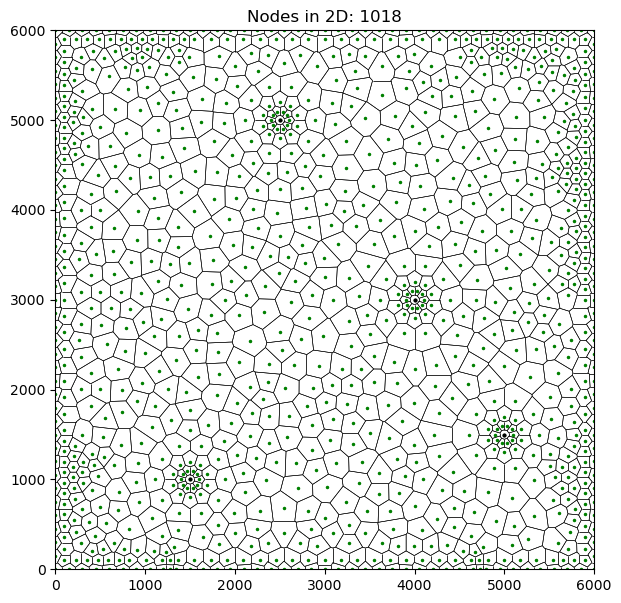

In [3]:
include_fault = False
# TRIANGULAR
P.cell2dtri, P.xcyctri, P.verticestri, P.tri, trinodes = createcell2d(P, grid = 'tri', fault = include_fault)
#plot_cell2d_tri(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

# VORONOI
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = include_fault)      
plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

### 3. Geological model

In [4]:
#----------- GEO MODEL PARAMETERS-------------------
#P.control_points = (['CP1', 'control', 3000, 3000, -230, -200, 'c', 'lower', np.nan, np.nan, np.nan],) 
P.control_points = ([])

# ----------- PREPARE GOEMODEL----------------------------
data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "pinchout_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")
P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = False)     # Prepare geomodel inputs
#print(P.strat)
#P.data

In [5]:
# -------------- CREATE GEOMODEL-------------------
geomodel = create_geomodel_loopshowcase(P, include_fault = False) # Make geomodel

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\skimage\util\dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [6]:
geomodel.update()

C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\ipywidgets\widgets\widget.py:438

  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
print(geomodel.bounding_box.nsteps)
geomodel.bounding_box.nelements = 1e6
print(geomodel.bounding_box.nsteps)
surfaces1 = geomodel["upper"].surfaces([-50])
surfaces2 = geomodel["lower"].surfaces([-100, -200])

[50 50 25]
[229 229  20]


In [8]:
"""import pyvista as pv
p = pv.Plotter()
p.add_mesh(surfaces1[0].vtk)
p.show()

mesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3])

structured2d = StructuredGrid2D(
    origin=np.zeros(2), step_vector=np.ones(2), nsteps=np.ones(2, dtype=int) * 11
)
pts = structured2d.barycentre

z = mesh.evaluate_value(pts, surfaces[0].vertices[:, 2])"""

'import pyvista as pv\np = pv.Plotter()\np.add_mesh(surfaces1[0].vtk)\np.show()\n\nmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3])\n\nstructured2d = StructuredGrid2D(\n    origin=np.zeros(2), step_vector=np.ones(2), nsteps=np.ones(2, dtype=int) * 11\n)\npts = structured2d.barycentre\n\nz = mesh.evaluate_value(pts, surfaces[0].vertices[:, 2])'

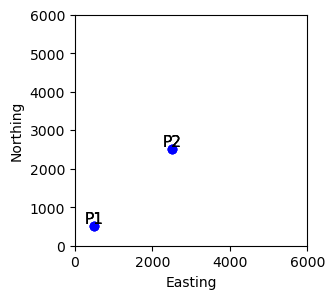

In [9]:
#P.geomodel.feature_names()
plot_bores(P)

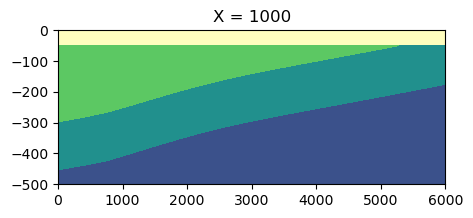

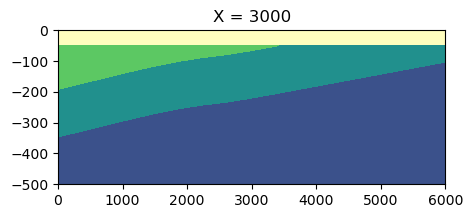

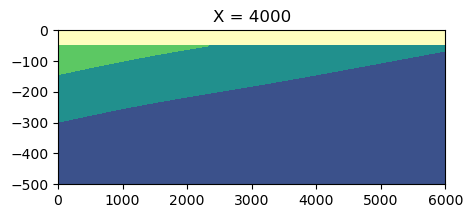

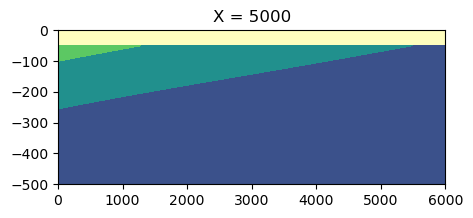

In [10]:
# Plot geo model
upper_levels, lower_levels = [-99999, -50, 0, 99999], [-99999, -200, -100, -50, 99999]
plot_geo_2D(geomodel, 1000, upper_levels, lower_levels)
plot_geo_2D(geomodel, 3000, upper_levels, lower_levels)
plot_geo_2D(geomodel, 4000, upper_levels, lower_levels)
plot_geo_2D(geomodel, 5000, upper_levels, lower_levels)

In [11]:
P.strat

,sequence,unit,lithid,val,color
0,upper,a,0,-50,green
1,lower,b,1,-100,palegoldenrod
2,lower,c,2,-200,peru
3,lower,d,3,-300,moccasin


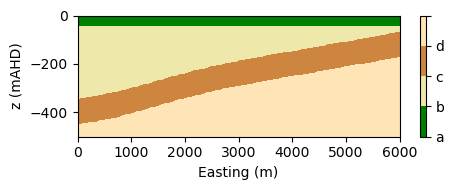

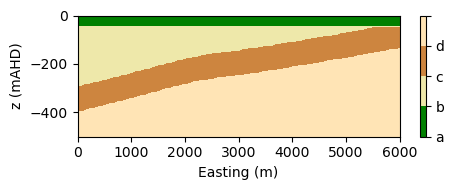

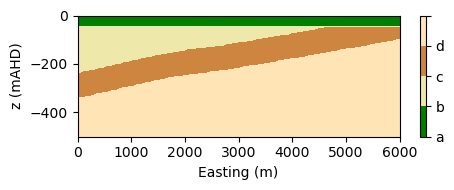

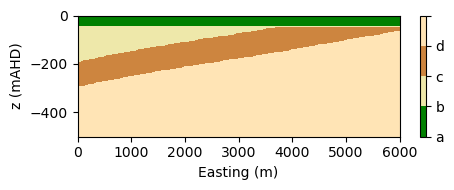

In [12]:
delx, delz = 100, 100
x, z = np.linspace(P.x0, P.x1, delx), np.linspace(P.z0, P.z1, delz)
xx, zz = np.meshgrid(x, z)
y_transects = [1000, 2000, 3000, 4000]        

for j in range(4):
    yy = np.zeros_like(xx)
    yy[:] = y_transects[j]
    geo = geomodel.evaluate_model(np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T).reshape(np.shape(xx))  
    plt.figure(figsize=(5, 2))
    plt.subplot(111)
    plt.contourf(xx,zz,geo,[-1, 0, 1, 2, 3],colors=P.strat["color"],)

    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(['a','b','c','d',' ']) #P.strat.unit.tolist(), verticalalignment = 'center')
    plt.ylabel('z (mAHD)')
    plt.xlabel('Easting (m)')
    plt.tight_layout()

    #plt.savefig('Transect',dpi = 450)

### 4. Flow model

In [13]:
print(flopy.__version__)

3.3.6


In [14]:
P.hk = [1, 0.1, 10, 0.1] 
P.vk = [i/10 for i in P.hk]
P.geomodel = geomodel

# Initiate models
M = Model('loopshowcase', P, plan = 'vor', transect = 'con') 
M.create_lith_dis_arrays(P)     # Create lithology and discretisation arrays (DIS)
M.create_prop_arrays(P)         # Create property arrays (NPF)
M.create_flow_package_arrays(P) # Create flow packages (CHD, RCH, IC, WEL, OBS)
print(M.modelname, ' has ', M.nnodes_div, ' nodes.')

   Creating lithology and discretisation arrays for  loopshowcase  ...
   Creating property arrays for  loopshowcase  ...
   Adding flow packages to  loopshowcase  ...
   Time taken =  0.888515
loopshowcase  has  12216  nodes.


In [15]:
# Plot lithology
#multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1) 
#multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 1000, X1 = P.x1, Y1 = 1000)
#multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 2000, X1 = P.x1, Y1 = 2000)
#multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 4000, X1 = P.x1, Y1 = 4000)
#multiplot_vgrid_transect(P, models = [M], array = 'lith', X0 = P.x0, Y0 = 5000, X1 = P.x1, Y1 = 5000)

In [17]:
# Write and run flow model
M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   

   Writing simulation and gwf for  loopshowcase  ...
Period =  Steady 
   Model success =  True
   run_time =  14.979784


In [18]:
#Export as VTK
f = os.path.join(vtk_workspace, "test", M.modelname)
M.gwf.export(f, fmt="vtk")

'../vtk_files\\test\\loopshowcase'

### 5. Plot Results

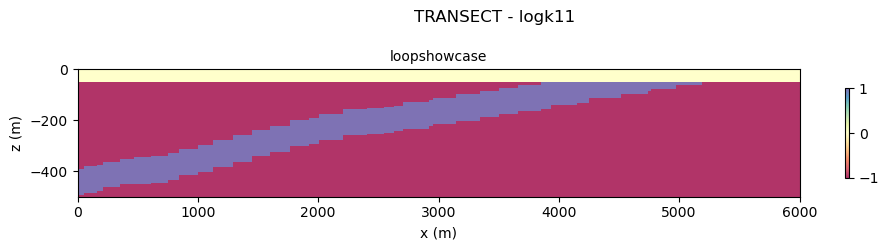

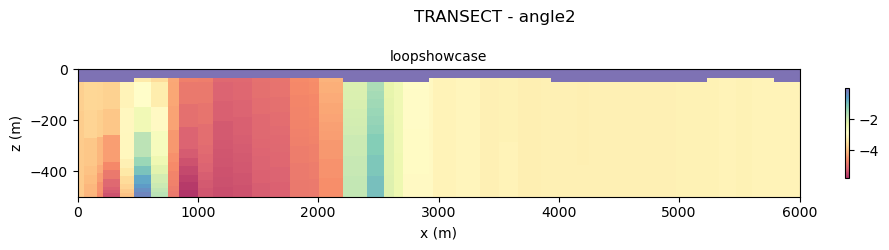

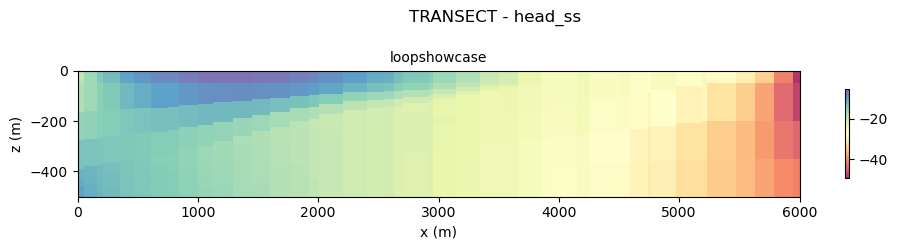

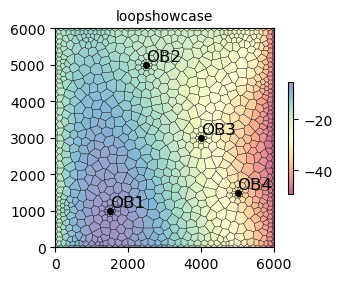

In [19]:
#plot_flow_features(P, [M])
multiplot_prop_transect(P, models = [M], array = 'logk11', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)
multiplot_prop_transect(P, models = [M], array = 'angle2', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = -6, vmax = 0)
multiplot_prop_transect(P, models = [M], array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)#vmin = vmin, vmax = vmax)
plot_bylayer(P, models = [M], layer = 2)#, vmin = -20, vmax = 5) 